### Как пользователи проходили обучение и как это влияло ли это на последующую покупку платных пакетов вопросов 
### - с точки зрения вероятности оплаты, размера платежа, времени для перехода к оплате?

### Насколько понятен пользователю процесс обучения ?

In [1823]:
# ОБЩАЯ ЧАСТЬ - СЧИТЫВАНИЕ И ОБРАБОТКА ДАННЫХ, ХАРАКТЕРИСТИКИ МАССИВОВ, ОБЩАЯ ХАРАКТЕРИСТИКА СОБЫТИЙ   
import pandas as pd

# считываем базовые файлы
ev = pd.read_csv('7_4_Events.csv', sep=',')  # 252334 rows x 6 columns : id > event_type > selected_level > start_time > tutorial_id > user_id 
pur = pd.read_csv('purchase.csv', sep=',')   # 5956 rows x 4 columns : id > user_id > event_datetime > amount 

# оставляем только юзеров с регой от 2018 г.
cond1=(ev['event_type']=='registration')&(ev['start_time']>='2018-01-01')&(ev['start_time']<'2019-01-01') # фильтр реги-2018
spisok_users=ev[cond1]['user_id'].to_list()  #список с номерами юзеров с регой-2018
ev = ev[ev['user_id'].isin(spisok_users)] # обновленный файл, в котором только юзеры с регой-2018: 66959 rows x 6 columns; 19926 уник
pur = pur[pur['user_id'].isin(spisok_users)] # обновленный файл, в котором только юзеры с регой-2018: 1600 rows x 4 columns; 1600 уник

# преобразовываем даты
ev['start_time'] = pd.to_datetime(ev['start_time'])
pur['event_datetime'] = pd.to_datetime(pur['event_datetime'])

# считаем структуру событий ФАКУЛЬТАТИВНО
print('Для зарегистрировавшихся в 2018 г. - список событий и их количество:', ev['event_type'].value_counts(), sep='\n')
print('purchase_pack    ', len(pur['user_id']))

Для зарегистрировавшихся в 2018 г. - список событий и их количество:
registration       19926
tutorial_start     18050
tutorial_finish    14904
level_choice        8342
pack_choice         5737
Name: event_type, dtype: int64
purchase_pack     1600


На 19926 пользователей приходится 
* 18050 стартов обучения, 
* 14904 финишей обучения и 
* 1600 покупок.
#
Как пользователи проходили обучение и влияло ли это на последующую покупку платных пакетов вопросов?
### ПЕРВЫЙ БЛОК анализа - 
### сколько раз сколько пользователей из 19926 начинали / оканчивали обучение, какая их часть позднее покупала пакеты вопросов и какой был средний платеж?

In [1824]:
# РАЗДЕЛ, ГДЕ РАССЧИТЫВАЕМ КОЛИЧЕСТВА СЛУЧИВШИХСЯ СТАРТОВ УЧЕБЫ И ЗАВИСИМОСТЬ ОТ НИХ ОПЛАТЫ  
# ищем, сколько раз юзеры начинали обучение
ev['tmp1'] = ev['event_type'].apply(lambda x: 1 if x == 'tutorial_start' else 0) # доп.столбец с 1 на начале учебы
ev_ser = ev.groupby('user_id')['tmp1'].sum()     #группировка по юзерам - количество стартов обучения
ev_ser_max = ev_ser.max()           # максимальное количество стартов обучения 
ev = ev.drop('tmp1', axis=1)        # удаляем вспомогательный столбец

# составляем список тех, кто прошел обучение n раз и список тех, кто потом совершил платеж и какой 
sp_ev = [0] * (ev_ser_max+1)  # список с номерами юзеров, которые начинали учебу n раз
sp_pur = [0] * (ev_ser_max+1)  # список с номерами юзеров, которые начинали учебу n раз и потом совершили платеж
sp_pur_mean = [0] * (ev_ser_max+1) # список со средним платежом по количеству стартов учебы
for i in range(ev_ser_max+1):
    sp_ev[i] = ev_ser[ev_ser == i].index
    sp_pur[i] = pur[pur['user_id'].isin(sp_ev[i])]['user_id']
    sp_pur_mean[i] = round(pur[pur['user_id'].isin(sp_ev[i])]['amount'].mean(),2)

# считаем их количества и доли совершивших оплату ЭТО ВТОРОЙ ВОПРОС ПРОЕКТА
sp_ev_cnt = [len(el) for el in sp_ev] # [8068, 9103, 1589, 427, 221, 109, 116, 94, 86, 113] количества юзеров, начинавших учебу 
sp_pur_cnt = [len(el) for el in sp_pur] # [22, 1207, 218, 51, 30, 16, 14, 12, 13, 17] из них - количества оплативших
conv = [round(sp_pur_cnt[i] * 100 / sp_ev_cnt[i],2) for i in range(ev_ser_max+1)] 
# [0.27, 13.26, 13.72, 11.94, 13.57, 14.68, 12.07, 12.77, 15.12, 15.04] - вероятность оплаты после n раз учебы 

sp_ev_cnt_tut = sum(sp_ev_cnt)- sp_ev_cnt[0] # количество начинавших учебу ВСЕГО 11858
sp_pur_cnt_tut = sum(sp_pur_cnt) - sp_pur_cnt[0] # из них - количество оплативших 1578
conv_tut = round(sp_pur_cnt_tut*100/sp_ev_cnt_tut,2) # вероятность оплаты после начала учебы 13.31
pur_tut = round(pur[~pur['user_id'].isin(sp_pur[0])]['amount'].mean(), 2) # средний платеж начала окончания учебы 110.49

print()
print('Количество начинавших обучение ВСЕГО  ', sp_ev_cnt_tut)
print('Вероятность оплаты в случае начала обучения, %  ',  conv_tut)
print('Средний платеж в случае начала обучения', pur_tut) 
print()
print('В зависимости от количества стартов обучения - ')
print('Количество начинавших обучение (ind=количеству стартов обучения)  ', sp_ev_cnt)
print('Вероятность оплаты в случае начала обучения (ind=количеству стартов обучения), %  ',conv)
print('Средний платеж в случае начала обучения (ind=количеству стартов обучения)', sp_pur_mean )


Количество начинавших обучение ВСЕГО   11858
Вероятность оплаты в случае начала обучения, %   13.31
Средний платеж в случае начала обучения 110.49

В зависимости от количества стартов обучения - 
Количество начинавших обучение (ind=количеству стартов обучения)   [8068, 9103, 1589, 427, 221, 109, 116, 94, 86, 113]
Вероятность оплаты в случае начала обучения (ind=количеству стартов обучения), %   [0.27, 13.26, 13.72, 11.94, 13.57, 14.68, 12.07, 12.77, 15.12, 15.04]
Средний платеж в случае начала обучения (ind=количеству стартов обучения) [128.41, 109.76, 114.45, 111.27, 98.33, 121.88, 119.64, 110.42, 103.85, 117.65]


In [1825]:
# СВОДНАЯ ТАБЛИЦА ИЗ СПИСКОВ ВЫШЕ
print()
res2 = pd.DataFrame(
    {'start_tut,pers': sp_ev_cnt, 
    'purch_start,pers': sp_pur_cnt,
    'purch/start,%': conv,
    'purch/start,mean': sp_pur_mean}
)
print('В отчет о результатах исследования:')
print('Таблица 1')
print('Сводная таблица о влиянии НАЧАЛА обучения на совершение платежа, по количеству прохождений обучения:')
print(res2)
print('Обозначения:')
print('start_tut,pers - количество пользователей по количеству стартов обучения',
    'purch_start,pers - из них совершивших платеж',
    'purch/start,% - доля совершивших платеж в проходивших обучение, по количеству стартов, %',
    'purch/start,mean - средний платеж проходивших обучение, по количеству стартов', sep='\n')


В отчет о результатах исследования:
Таблица 1
Сводная таблица о влиянии НАЧАЛА обучения на совершение платежа, по количеству прохождений обучения:
   start_tut,pers  purch_start,pers  purch/start,%  purch/start,mean
0            8068                22           0.27            128.41
1            9103              1207          13.26            109.76
2            1589               218          13.72            114.45
3             427                51          11.94            111.27
4             221                30          13.57             98.33
5             109                16          14.68            121.88
6             116                14          12.07            119.64
7              94                12          12.77            110.42
8              86                13          15.12            103.85
9             113                17          15.04            117.65
Обозначения:
start_tut,pers - количество пользователей по количеству стартов обучения
purch_s

In [1826]:
# РАЗДЕЛ, ГДЕ РАССЧИТЫВАЕМ КОЛИЧЕСТВА СЛУЧИВШИХСЯ ФИНИШЕЙ УЧЕБЫ И ЗАВИСИМОСТЬ ОТ НИХ ОПЛАТЫ 
# ищем, сколько раз юзеры оканчивали обучение
ev['tmp2'] = ev['event_type'].apply(lambda x: 1 if x == 'tutorial_finish' else 0) # доп.столбец с 1 на конце учебы
ev_serr = ev.groupby('user_id')['tmp2'].sum()     #группировка по юзерам - количество финишей обучения
ev_serr_max = ev_serr.max()           # максимальное количество финишей обучения 
ev = ev.drop('tmp2', axis=1)        # удаляем вспомогательный столбец

# составляем список тех, кто окончил обучение n раз и список тех, кто потом совершил платеж 
sp_evr = [0] * (ev_serr_max+1)  # список номеров юзеров, которые окончили учебу n раз
sp_purr = [0] * (ev_serr_max+1)  # список номеров юзеров, которые окончили учебу n раз и потом совершили платеж
sp_purr_mean = [0] * (ev_serr_max+1)  # список со средним платежом по количеству финишей учебы
for i in range(ev_serr_max+1):
    sp_evr[i] = ev_serr[ev_serr == i].index
    sp_purr[i] = pur[pur['user_id'].isin(sp_evr[i])]['user_id']
    sp_purr_mean[i] = round(pur[pur['user_id'].isin(sp_evr[i])]['amount'].mean(),2)
    
# считаем их количества и доли совершивших оплату ЭТО ВТОРОЙ ВОПРОС ПРОЕКТА
sp_evr_cnt = [len(el) for el in sp_evr] # [9676, 8015, 1321, 345, 178, 117, 101, 97, 54, 22] количества окончивших учебу 
sp_purr_cnt = [len(el) for el in sp_purr] # [153, 1143, 182, 44, 19, 19, 15, 15, 6, 4] из них - количества оплативших
convr = [round(sp_purr_cnt[i] * 100 / sp_evr_cnt[i],2) for i in range(ev_serr_max+1)] 
# [1.58, 14.26, 13.78, 12.75, 10.67, 16.24, 14.85, 15.46, 11.11, 18.18] - вероятность оплаты после n раз окончания учебы 

sp_evr_cnt_tut = sum(sp_evr_cnt)- sp_evr_cnt[0] # количество окончивших учебу ВСЕГО 10250
sp_purr_cnt_tut = sum(sp_purr_cnt) - sp_purr_cnt[0] # из них - количество оплативших 1447
convr_tut = round(sp_purr_cnt_tut*100/sp_evr_cnt_tut,2) # вероятность оплаты после окончания учебы 14.12
purr_tut = round(pur[~pur['user_id'].isin(sp_purr[0])]['amount'].mean(), 2) # средний платеж после окончания учебы 110.99

print()
print('Количество окончивших обучение ВСЕГО  ', sp_evr_cnt_tut)
print('Вероятность оплаты в случае окончания обучения, %  ', convr_tut)
print('Средний платеж в случае окончания обучения', purr_tut) 
print()
print('В зависимости от количества финишей обучения - ')
print('Количество окончивших обучение (ind=количеству финишей обучения)  ',sp_evr_cnt)
print('Вероятность оплаты в случае завершения обучения (ind=количеству финишей обучения), %  ', convr)
print('Средний платеж в случае завершения обучения (ind=количеству финишей обучения)', sp_purr_mean)


Количество окончивших обучение ВСЕГО   10250
Вероятность оплаты в случае окончания обучения, %   14.12
Средний платеж в случае окончания обучения 110.99

В зависимости от количества финишей обучения - 
Количество окончивших обучение (ind=количеству финишей обучения)   [9676, 8015, 1321, 345, 178, 117, 101, 97, 54, 22]
Вероятность оплаты в случае завершения обучения (ind=количеству финишей обучения), %   [1.58, 14.26, 13.78, 12.75, 10.67, 16.24, 14.85, 15.46, 11.11, 18.18]
Средний платеж в случае завершения обучения (ind=количеству финишей обучения) [108.33, 110.26, 113.32, 124.43, 102.63, 102.63, 108.33, 116.67, 133.33, 100.0]


In [1827]:
# СВОДНАЯ ТАБЛИЦА ИЗ СПИСКОВ ВЫШЕ
print()
res3 = pd.DataFrame(
    {'finish_tut,pers': sp_evr_cnt, 
    'purch_finish,pers': sp_purr_cnt,
    'purch/finish,%': convr,
    'purch/finish,mean': sp_purr_mean,}
)
print('В отчет о результатах исследования:')
print('Таблица 2')
print('Сводная таблица о влиянии ЗАВЕРШЕНИЯ обучения на совершение платежа, по количеству прохождений обучения:')
print(res3)
print('Обозначения:')
print('finish_tut,pers - количество пользователей по количеству завершенных обучений', 
    'purch_finish,pers - из них совершивших платеж',
    'purch/finish,% - доля совершивших платеж в завершивших обучение, по количеству финишей, %', 
    'purch/finish,mean - средний платеж завершивших обучение, по количеству финишей', sep='\n')


В отчет о результатах исследования:
Таблица 2
Сводная таблица о влиянии ЗАВЕРШЕНИЯ обучения на совершение платежа, по количеству прохождений обучения:
   finish_tut,pers  purch_finish,pers  purch/finish,%  purch/finish,mean
0             9676                153            1.58             108.33
1             8015               1143           14.26             110.26
2             1321                182           13.78             113.32
3              345                 44           12.75             124.43
4              178                 19           10.67             102.63
5              117                 19           16.24             102.63
6              101                 15           14.85             108.33
7               97                 15           15.46             116.67
8               54                  6           11.11             133.33
9               22                  4           18.18             100.00
Обозначения:
finish_tut,pers - количество пол

В отчет о результатах исследования:
График 1
Вероятность покупки платного пакета вопросов и средний платеж в зависимости от количества стартов / финишей обучения


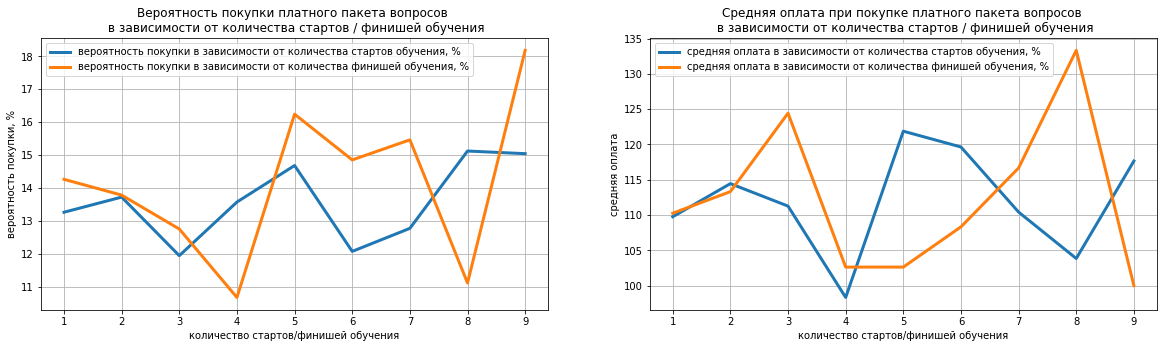

In [1828]:
# ГРАФИКА
# import matplotlib.pyplot as plt
%matplotlib inline

print('В отчет о результатах исследования:')
print('График 1')
print('Вероятность покупки платного пакета вопросов и средний платеж в зависимости от количества стартов / финишей обучения')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))	

axes[0].plot(range(1, 10), conv[1:], label='вероятность покупки в зависимости от количества стартов обучения, %', lw=3)
axes[0].plot(range(1, 10), convr[1:], label='вероятность покупки в зависимости от количества финишей обучения, %', lw=3)
axes[0].set_title('Вероятность покупки платного пакета вопросов \n в зависимости от количества стартов / финишей обучения', fontsize=12)
axes[0].set_xlabel('количество стартов/финишей обучения')
axes[0].set_ylabel('вероятность покупки, %')
axes[0].grid()
axes[0].legend()

axes[1].plot(range(1, 10), sp_pur_mean[1:], label='средняя оплата в зависимости от количества стартов обучения, %', lw=3)
axes[1].plot(range(1, 10), sp_purr_mean[1:], label='средняя оплата в зависимости от количества финишей обучения, %', lw=3)
axes[1].set_title('Средняя оплата при покупке платного пакета вопросов \n в зависимости от количества стартов / финишей обучения', fontsize=12)
axes[1].set_xlabel('количество стартов/финишей обучения')
axes[1].set_ylabel('средняя оплата')
axes[1].grid()
axes[1].legend();


По результатам Блока1 обнаружено, что из 19926 пользователей: 
* 11858 пользователей начинали обучение от 1 до 9 раз, из них 13.31% позднее купили платный пакет вопросов, средний платеж 110.49 
* 10250 пользователей окончили обучение от 1 до 9 раз, из них 14.12% позднее купили платный пакет вопросов, средний платеж 110.99 

Обнаружено, что ни в терминах начала, ни в терминах завершения обучения, в среднем, 
### рост числа прохождений обучения (как минимум) не снижает ни вероятность покупки платного пакета вопросов, ни средний платеж. 
### Более того, можно предположить, что повторные обучения даже несколько повышают эту вероятность. 
### Гипотезу о том, что "успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло", следует признать правильной. 

По результатам Блока1 сформированы 
* Таблица 1. Сводная таблица о влиянии НАЧАЛА обучения на совершение платежа, по количеству прохождений обучения,
* Таблица 2. Сводная таблица о влиянии ЗАВЕРШЕНИЯ обучения на совершение платежа, по количеству прохождений обучения
* График 1. Вероятность покупки платного пакета вопросов и средний платеж в зависимости от количества стартов / финишей обучения  

Далее, из 19926 зарегистрировавшихся пользователей какое количество 
не начинало учебу / начало, но не окончило учебу / окончило учебу и как они продвигались к 1600 покупкам?
### ВТОРОЙ БЛОК анализа - три воронки: 
### регистрация >>> выбор уровня бесплатных вопросов >>> выбор пакета бесплатных вопросов >>> покупка платного пакета вопросов

In [1829]:
# это про ПЕРВЫЙ ВОПРОС задания, ПРО ТАЙМИНГ ГРУПП
# сначала - группы юзеров и воронка 

# формируем три группы юзеров - без обучения, с оконченным обучением, с неоконченным обучением
gr_notut = sp_ev[0] # список индексов тех, кто не начинал учебу 8068
gr_nofintut = sp_evr[0].difference(gr_notut) # список индексов тех, кто начинал, но не окончил учебу 1608
gr_fintut = ev_ser[ev_ser >0].index.difference(gr_nofintut) # список индексов тех, кто начал и окончил учебу 10250
# сумма по трем группам 8068 + 1608 + 10250 = 19926 - все зарегившиеся в 2018 норм

# считаем выбравших уровень сложности вопросов по трем группам юзеров - без обучения, с оконченным обучением, с неоконченным обучением  
ev['tmp3'] = ev['event_type'].apply(lambda x: 1 if x == 'level_choice' else 0) # доп.столбец с 1 на выборе уровня
ev_tmp3 = ev.groupby('user_id')['tmp3'].sum()
s_level = ev_tmp3[ev_tmp3 > 0].index              # список индексов всех выбравших уровень 8342
ev = ev.drop('tmp3', axis=1)        # удаляем вспомогательный столбец
del ev_tmp3                         # удаляем вспомогательный фр
gr_notut_level = gr_notut.intersection(s_level) # без обучения выбрали уровень 98
gr_nofintut_level = gr_nofintut.intersection(s_level) # не окончив обучения выбрали уровень 743
gr_fintut_level = gr_fintut.intersection(s_level) # по окончании обучения выбрали уровень 7501

# считаем выбравших бесплатные пакеты вопросов по трем группам юзеров - без обучения, с оконченным обучением, с неоконченным обучением  
ev['tmp4'] = ev['event_type'].apply(lambda x: 1 if x == 'pack_choice' else 0) # доп.столбец с 1 на бесплатном пакете
ev_tmp4 = ev.groupby('user_id')['tmp4'].sum()
s_pack = ev_tmp4[ev_tmp4 > 0].index              # список индексов всех выбравших пакет вопросов 5737
ev = ev.drop('tmp4', axis=1)        # удаляем вспомогательный столбец
del ev_tmp4                         # удаляем вспомогательный фр
gr_notut_pack = gr_notut.intersection(s_pack) # без обучения выбрали бесплатный пакет 74
gr_nofintut_pack = gr_nofintut.intersection(s_pack) # не окончив обучения выбрали бесплатный пакет 487
gr_fintut_pack = gr_fintut.intersection(s_pack) # по окончании обучения выбрали бесплатный пакет 5176
# сумма по трем группам 74 + 487 + 5176 = 5737 - норм

# считаем, сколько оплативших по трем группам юзеров - без обучения, с оконченным обучением, с неоконченным обучением  
gr_notut_pur = pur[pur['user_id'].isin(gr_notut)]['user_id'] # оплатившие из необучавшихся 22
gr_nofintut_pur = pur[pur['user_id'].isin(gr_nofintut)]['user_id'] # оплатившие из неокончивших учебу 131
gr_fintut_pur = pur[pur['user_id'].isin(gr_fintut)]['user_id'] # оплатившие из окончивших обучение 1447
# сумма по трем группам 22 + 131 + 1447 = 1600 - норм

#ВОРОНКА ПЕЧАТЬ
print('В отчет о результатах исследования:')
print('Таблица 3')
print('Группы пользователей: ВОРОНКА от регистрации к покупке платных вопросов. Численность и динамика в %')
# print()
print('         Группа "без обучения"')
print('Всего:                               ', len(gr_notut), 'человек')
print('Выбрали уровень сложности:           ', len(gr_notut_level), 'или в % от их стартовой численности: ', round(len(gr_notut_level)*100/len(gr_notut), 2))
print('Выбрали пакет бесплатных вопросов:   ', len(gr_notut_pack), 'или в % от их стартовой численности: ', round(len(gr_notut_pack)*100/len(gr_notut), 2))
print('Купили платный пакет вопросов:       ', len(gr_notut_pur), 'или в % от их стартовой численности: ', round(len(gr_notut_pur)*100/len(gr_notut), 2))
# print()

print('         Группа "с неоконченным обучением"')
print('Всего:                               ', len(gr_nofintut), 'человек')
print('Выбрали уровень сложности:           ', len(gr_nofintut_level), 'или в % от их стартовой численности: ', round(len(gr_nofintut_level)*100/len(gr_nofintut), 2))
print('Выбрали пакет бесплатных вопросов:   ', len(gr_nofintut_pack), 'или в % от их стартовой численности: ', round(len(gr_nofintut_pack)*100/len(gr_nofintut), 2))
print('Купили платный пакет вопросов:       ', len(gr_nofintut_pur), 'или в % от их стартовой численности: ', round(len(gr_nofintut_pur)*100/len(gr_nofintut), 2))
# print()

print('         Группа "с оконченным обучением"')
print('Всего:                               ', len(gr_fintut), 'человек')
print('Выбрали уровень сложности:           ', len(gr_fintut_level), 'или в % от их стартовой численности: ', round(len(gr_fintut_level)*100/len(gr_fintut), 2))
print('Выбрали пакет бесплатных вопросов:   ', len(gr_fintut_pack), 'или в % от их стартовой численности: ', round(len(gr_fintut_pack)*100/len(gr_fintut), 2))
print('Купили платный пакет вопросов:       ', len(gr_fintut_pur), 'или в % от их стартовой численности: ', round(len(gr_fintut_pur)*100/len(gr_fintut), 2))

В отчет о результатах исследования:
Таблица 3
Группы пользователей: ВОРОНКА от регистрации к покупке платных вопросов. Численность и динамика в %
         Группа "без обучения"
Всего:                                8068 человек
Выбрали уровень сложности:            98 или в % от их стартовой численности:  1.21
Выбрали пакет бесплатных вопросов:    74 или в % от их стартовой численности:  0.92
Купили платный пакет вопросов:        22 или в % от их стартовой численности:  0.27
         Группа "с неоконченным обучением"
Всего:                                1608 человек
Выбрали уровень сложности:            743 или в % от их стартовой численности:  46.21
Выбрали пакет бесплатных вопросов:    487 или в % от их стартовой численности:  30.29
Купили платный пакет вопросов:        131 или в % от их стартовой численности:  8.15
         Группа "с оконченным обучением"
Всего:                                10250 человек
Выбрали уровень сложности:            7501 или в % от их стартовой численнос

В отчет о результатах исследования:
График 2
ВОРОНКА, или численность пользователей различных групп при прохождении этапов игры от регистрации к покупке платных вопросов


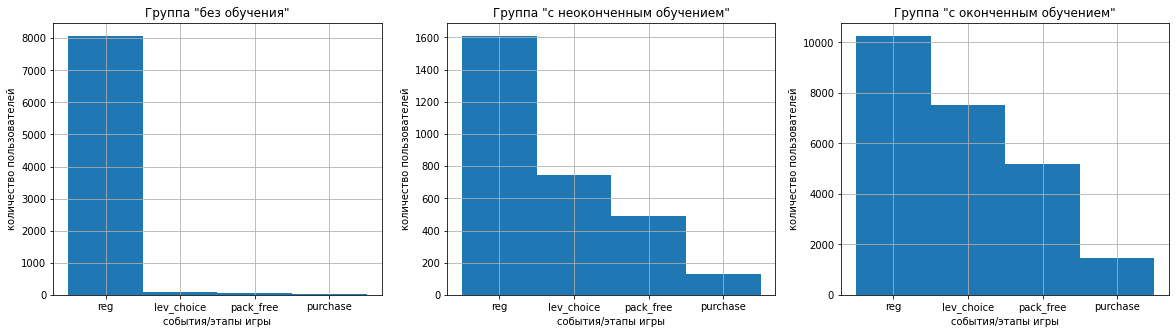

In [1830]:
# ГРАФИКА
print('В отчет о результатах исследования:')
print('График 2')
print('ВОРОНКА, или численность пользователей различных групп при прохождении этапов игры от регистрации к покупке платных вопросов')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))	

axes[0].bar(x=['reg', 'lev_choice', 'pack_free', 'purchase'], height=[len(gr_notut), len(gr_notut_level), len(gr_notut_pack), len(gr_notut_pur)], width=1, lw=3)
axes[0].set_title('Группа "без обучения"', fontsize=12)
axes[0].set_ylabel('количество пользователей')
axes[0].set_xlabel('события/этапы игры')
axes[0].grid();

axes[1].bar(x=['reg', 'lev_choice', 'pack_free', 'purchase'], height=[len(gr_nofintut), len(gr_nofintut_level), len(gr_nofintut_pack), len(gr_nofintut_pur)], width=1, lw=3)
axes[1].set_title('Группа "с неоконченным обучением"', fontsize=12)
axes[1].set_ylabel('количество пользователей')
axes[1].set_xlabel('события/этапы игры')
axes[1].grid();

axes[2].bar(x=['reg', 'lev_choice', 'pack_free', 'purchase'], height=[len(gr_fintut), len(gr_fintut_level), len(gr_fintut_pack), len(gr_fintut_pur)], width=1, lw=3)
axes[2].set_title('Группа "с оконченным обучением"', fontsize=12)
axes[2].set_ylabel('количество пользователей')
axes[2].set_xlabel('события/этапы игры')
axes[2].grid();


По результатам Блока2 обнаружено, что из 19926 пользователей: 
* - 8068 не начинали обучение и 22 (или 0.27%) купили платный пакет, 
* - 1608 начали, но не окончили обучение и 131 (или 8.15%) купил платный пакет, 
* - 10250 окончили обучение и 1447 (14.12%) купили платный пакет вопросов. 

Обнаружено, что 
### Даже просто попытка обучения (неоконченное обучение) заметно повышает вероятность последующей оплаты, 
### Оконченное обучение увеличивает эту вероятность на порядок

По результатам Блока2 сформированы 
* Таблица 3. Группы пользователей: ВОРОНКА от регистрации к покупке платных вопросов. Численность и динамика в %,
* График 2. ВОРОНКА, или численность пользователей различных групп при прохождении этапов игры от регистрации к покупке платных вопросов  

Далее, эти группы пользователей, какое время они затрачивали, продвигаясь к 1600 покупкам?
### ТРЕТИЙ БЛОК анализа - 
### как по группам соотносится среднее время для прохождения этапов: 
### регистрация >>> выбор уровня бесплатных вопросов >>> выбор пакета бесплатных вопросов >>> покупка платного пакета вопросов

In [1831]:
# ЭТО ЧИСТЫЙ ПЕРВЫЙ ВОПРОС ЗАДАНИЯ: какое время требуется для прохождения уровней игры пользователям из разных групп?

# определяем моменты событий
time_reg = ev[ev['event_type'] == 'registration'][['user_id', 'start_time']]
time_level = ev[ev['event_type'] == 'level_choice'][['user_id', 'start_time']]
time_pack = ev[ev['event_type'] == 'pack_choice'][['user_id', 'start_time']]
# определяем разницу между событиями
delt = time_reg.merge(time_level, on='user_id', how='left').merge(time_pack, on='user_id', how='left').merge(pur, on='user_id', how='left')
delt.columns = ['user_id', 'registration', 'level_ch', 'pack_ch', 'id', 'purchase', 'am']
delt = delt.drop(['id','am'], axis=1)
delt['step1'] = delt['level_ch'] - delt['registration']
delt['step2'] = delt['pack_ch'] - delt['registration']
delt['step3'] = delt['purchase'] - delt['registration']

step0 = ['Группа "без обучения"', 'Группа "с неоконченным обучением"', 'Группа "с оконченным обучением"']

step1 = [0, 0, 0] # время от реги до выбора уровня вопросов 
step1[0] = delt[delt['user_id'].isin(gr_notut_level)]['step1'].mean()
step1[1] = delt[delt['user_id'].isin(gr_nofintut_level)]['step1'].mean()
step1[2] = delt[delt['user_id'].isin(gr_fintut_level)]['step1'].mean()
 
step2 = [0, 0, 0] # время от реги до выбора бесплатного пакета вопросов 
step2[0] = delt[delt['user_id'].isin(gr_notut_pack)]['step2'].mean()
step2[1] = delt[delt['user_id'].isin(gr_nofintut_pack)]['step2'].mean()
step2[2] = delt[delt['user_id'].isin(gr_fintut_pack)]['step2'].mean()

step3 = [0, 0, 0] # время от реги до покупки платного пакета вопросов 
step3[0] = delt[delt['user_id'].isin(gr_notut_pur)]['step3'].mean()
step3[1] = delt[delt['user_id'].isin(gr_nofintut_pur)]['step3'].mean()
step3[2] = delt[delt['user_id'].isin(gr_fintut_pur)]['step3'].mean()


for i in range(3):
    print(step0[i], ': среднее время от регистрации до выбора уровня вопросов - ', step1[i])
    print(step0[i], ': среднее время от регистрации до выбора бесплатного пакета вопросов - ', step2[i])
    print(step0[i], ': среднее время от регистрации до покупки платного пакета вопросов - ', step3[i])
    print()

Группа "без обучения" : среднее время от регистрации до выбора уровня вопросов -  0 days 05:15:33.122448979
Группа "без обучения" : среднее время от регистрации до выбора бесплатного пакета вопросов -  0 days 05:07:16.175675675
Группа "без обучения" : среднее время от регистрации до покупки платного пакета вопросов -  4 days 09:06:01.909090909

Группа "с неоконченным обучением" : среднее время от регистрации до выбора уровня вопросов -  0 days 08:12:57.551816958
Группа "с неоконченным обучением" : среднее время от регистрации до выбора бесплатного пакета вопросов -  0 days 08:22:32.392197125
Группа "с неоконченным обучением" : среднее время от регистрации до покупки платного пакета вопросов -  4 days 05:32:53.213740458

Группа "с оконченным обучением" : среднее время от регистрации до выбора уровня вопросов -  0 days 07:05:36.854819357
Группа "с оконченным обучением" : среднее время от регистрации до выбора бесплатного пакета вопросов -  0 days 07:10:35.660162287
Группа "с оконченным о

In [1832]:
res6 = pd.DataFrame(
    {'level': [round(el/pd.Timedelta('1  hour'), 2) for el in step1], 
    'pack': [round(el/pd.Timedelta('1  hour'), 2) for el in step2],
    'purch': [round(el/pd.Timedelta('1  hour'), 2) for el in step3]}
    )
res6.index = ['Группа "без обучения"', 'Группа "с неоконченным обучением"', 'Группа "с оконченным обучением"']
print()
print('В отчет о результатах исследования:')
print('Таблица 4')
print('Время прохождения этапов игры для пользователей из различных групп, от регистрации, часов')
print(res6)
print('Обозначения:')
print('level - выбор уровня бесплатных вопросов', 
    'pack - выбор бесплатного пакета вопросов',
    'purchase - покупка платного пакета вопросов', sep='\n'
)


В отчет о результатах исследования:
Таблица 4
Время прохождения этапов игры для пользователей из различных групп, от регистрации, часов
                                   level  pack   purch
Группа "без обучения"               5.26  5.12  105.10
Группа "с неоконченным обучением"   8.22  8.38  101.55
Группа "с оконченным обучением"     7.09  7.18   96.50
Обозначения:
level - выбор уровня бесплатных вопросов
pack - выбор бесплатного пакета вопросов
purchase - покупка платного пакета вопросов


In [1833]:
print('Для двух целевых групп (без обучения и с оконченным обучением) скорость прохождения этапов:')
if step1[0] > step1[2]:
    print(step0[2], 'БЫСТРЕЕ переходит от регистрации к выбору УРОВНЯ СЛОЖНОСТИ бесплатных вопросов, чем', step0[0], 'на', step1[0] - step1[2])
else:
    print(step0[0], 'БЫСТРЕЕ переходит от регистрации к выбору УРОВНЯ СЛОЖНОСТИ бесплатных вопросов, чем', step0[2], 'на', step1[2] - step1[0])

if step2[0] > step2[2]:
    print(step0[2], 'БЫСТРЕЕ переходит от регистрации к выбору БЕСПЛАТНОГО ПАКЕТА вопросов, чем', step0[0], 'на', step2[0] - step2[2])
else:
    print(step0[0], 'БЫСТРЕЕ переходит от регистрации к выбору БЕСПЛАТНОГО ПАКЕТА вопросов, чем', step0[2], 'на', step2[2] - step2[0])

if step3[0] > step3[2]:
    print(step0[2], 'БЫСТРЕЕ переходит от регистрации к ПОКУПКЕ платного пакета вопросов, чем', step0[0], 'на', step3[0] - step3[2])
else:
    print(step0[0], 'БЫСТРЕЕ переходит от регистрации к ПОКУПКЕ платного пакета вопросов, чем', step0[2], 'на', step3[2] - step3[0])


Для двух целевых групп (без обучения и с оконченным обучением) скорость прохождения этапов:
Группа "без обучения" БЫСТРЕЕ переходит от регистрации к выбору УРОВНЯ СЛОЖНОСТИ бесплатных вопросов, чем Группа "с оконченным обучением" на 0 days 01:50:03.732370378
Группа "без обучения" БЫСТРЕЕ переходит от регистрации к выбору БЕСПЛАТНОГО ПАКЕТА вопросов, чем Группа "с оконченным обучением" на 0 days 02:03:19.484486612
Группа "с оконченным обучением" БЫСТРЕЕ переходит от регистрации к ПОКУПКЕ платного пакета вопросов, чем Группа "без обучения" на 0 days 08:35:58.661682478


In [1834]:
# ЗДЕСЬ СКОРОСТИ ПО ЭТАПАМ ДЛЯ ТРЕХ ГРУПП
mi = min(step1)
ma = max(step1)
for i in range(3):
    if step1[i] == mi:
        i_mi = i
    elif step1[i] == ma:
        i_ma = i
print('По увеличению времени от РЕГИСТРАЦИИ к выбору УРОВНЯ СЛОЖНОСТИ бесплатных вопросов, от самого быстрого к самому медленному:')
print(step0[i_mi], '>>>', step0[3 - i_mi - i_ma], '>>>', step0[i_ma])
print('Разница среднего времени на прохождение этапа:')
print('--- между самым быстрым и средним -', step1[3 - i_mi - i_ma] - step1[i_mi])
print('--- между средним и самым медленным - ', step1[i_ma] - step1[3 - i_mi - i_ma])
print('--- между самым быстрым и самым медленным - ', step1[i_ma] - step1[i_mi])
print()
mi = min(step2)
ma = max(step2)
for i in range(3):
    if step2[i] == mi:
        i_mi = i
    elif step2[i] == ma:
        i_ma = i
print('По увеличению времени от РЕГИСТРАЦИИ к выбору БЕСПЛАТНОГО ПАКЕТА вопросов, от самого быстрого к самому медленному:')
print(step0[i_mi], '>>>', step0[3 - i_mi - i_ma], '>>>', step0[i_ma])
print('Разница среднего времени на прохождение этапа:')
print('--- между самым быстрым и средним -', step2[3 - i_mi - i_ma] - step2[i_mi])
print('--- между средним и самым медленным - ', step2[i_ma] - step2[3 - i_mi - i_ma])
print('--- между самым быстрым и самым медленным - ', step2[i_ma] - step2[i_mi])
print()
mi = min(step3)
ma = max(step3)
for i in range(3):
    if step3[i] == mi:
        i_mi = i
    elif step3[i] == ma:
        i_ma = i
print('По увеличению времени от РЕГИСТРАЦИИ к ПОКУПКЕ платного пакета вопросов, от самого быстрого к самому медленному:')
print(step0[i_mi], '>>>', step0[3 - i_mi - i_ma], '>>>', step0[i_ma])
print('Разница среднего времени на прохождение этапа:')
print('--- между самым быстрым и средним -', step3[3 - i_mi - i_ma] - step3[i_mi])
print('--- между средним и самым медленным - ', step3[i_ma] - step3[3 - i_mi - i_ma])
print('--- между самым быстрым и самым медленным - ', step3[i_ma] - step3[i_mi])
print()

По увеличению времени от РЕГИСТРАЦИИ к выбору УРОВНЯ СЛОЖНОСТИ бесплатных вопросов, от самого быстрого к самому медленному:
Группа "без обучения" >>> Группа "с оконченным обучением" >>> Группа "с неоконченным обучением"
Разница среднего времени на прохождение этапа:
--- между самым быстрым и средним - 0 days 01:50:03.732370378
--- между средним и самым медленным -  0 days 01:07:20.696997601
--- между самым быстрым и самым медленным -  0 days 02:57:24.429367979

По увеличению времени от РЕГИСТРАЦИИ к выбору БЕСПЛАТНОГО ПАКЕТА вопросов, от самого быстрого к самому медленному:
Группа "без обучения" >>> Группа "с оконченным обучением" >>> Группа "с неоконченным обучением"
Разница среднего времени на прохождение этапа:
--- между самым быстрым и средним - 0 days 02:03:19.484486612
--- между средним и самым медленным -  0 days 01:11:56.732034838
--- между самым быстрым и самым медленным -  0 days 03:15:16.216521450

По увеличению времени от РЕГИСТРАЦИИ к ПОКУПКЕ платного пакета вопросов, от с

В отчет о результатах исследования:
График 3
Время прохождения этапов игры пользователями различных групп


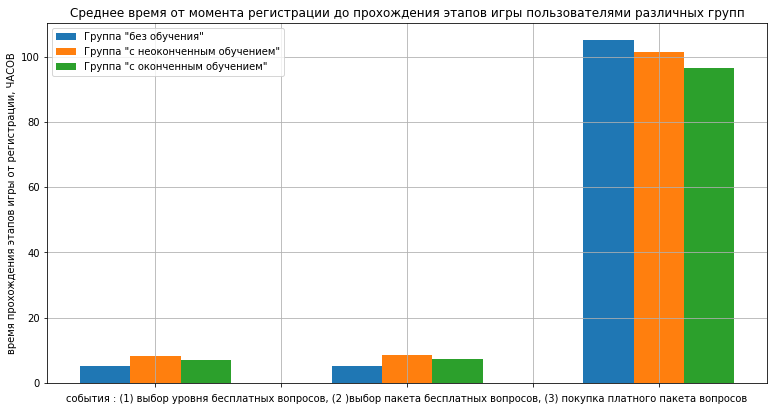

In [1835]:
# ГРАФИКА
print('В отчет о результатах исследования:')
print('График 3')
print('Время прохождения этапов игры пользователями различных групп')
fig = plt.figure(figsize=(10, 5))
axes = fig.add_axes([0, 0, 1, 1])
x1 = [0.8, 1.8, 2.8]
x2 = [1, 2, 3] 
x3 = [1.2, 2.2, 3.2]

y1 = [step1[0]/pd.Timedelta('1  hour'), step2[0]/pd.Timedelta('1  hour'), step3[0]/pd.Timedelta('1  hour')]
y2 = [step1[1]/pd.Timedelta('1  hour'), step2[1]/pd.Timedelta('1  hour'), step3[1]/pd.Timedelta('1  hour')]
y3 = [step1[2]/pd.Timedelta('1  hour'), step2[2]/pd.Timedelta('1  hour'), step3[2]/pd.Timedelta('1  hour')]
axes.bar(x1, y1, label='Группа "без обучения"', width = 0.2, lw=3) 
axes.bar(x2, y2, label='Группа "с неоконченным обучением"', width = 0.2, lw=3) 
axes.bar(x3, y3, label='Группа "с оконченным обучением"', width = 0.2, lw=3) 

axes.set_title('Среднее время от момента регистрации до прохождения этапов игры пользователями различных групп', fontsize=12)
axes.set_xlabel('события : (1) выбор уровня бесплатных вопросов, (2 )выбор пакета бесплатных вопросов, (3) покупка платного пакета вопросов')
axes.set_ylabel('время прохождения этапов игры от регистрации, ЧАСОВ')
axes.xaxis.set_ticklabels([])

# axes.set_yticks(range(0, 100000, 10000))
# axes.xaxis.set_tick_params(rotation=30)
axes.grid()
axes.legend();

### Обнаружено, что сам факт обучения, а тем более, его завершение значительно сокращает время от регистрации до покупки
### Если для выбора уровня бесплатных вопросов или пакета бесплатных вопросов пользователи без обучения гораздо быстрее, 
### то с точки зрения формирования выручки полезнее хотя бы начавшие обучение, а лучше - окончившие.
По результатам Блока3 сформированы 
* Таблица 4. Время прохождения этапов игры для пользователей из различных групп, от регистрации, часов
* График 3. Время прохождения этапов игры пользователями различных групп  

По результатам блоков 1-3: 
### Обучение - это полезно для выручки. Обучение
### 1. значительно повышает вероятность покупки платного пакета вопросов 
### 2. значительно сокращает время от регистрации до покупки 


###
### ЧЕТВЕРТЫЙ БЛОК анализа - 
### Насколько понятен процесс обучения?
Какая часть обучения начинается после этапа выбора сложности вопросов?
Как часто пользователи возвращаются на уровень обучения после попытки продвинуться дальше? 

In [1836]:
#ЭТО ТРЕТИЙ ВОПРОС задания
lev_ch = ev[ev['event_type'] == 'level_choice'][['user_id', 'start_time']]
tut_st = ev[ev['event_type'] == 'tutorial_start'][['user_id', 'start_time']]
lev_ch = lev_ch.merge(tut_st, on = 'user_id', how = 'left')
lev_ch.columns = ['user_id', 'tm_lev_choice', 'tm_tutorial_st']
lev_ch = lev_ch[lev_ch['tm_lev_choice'] <= lev_ch['tm_tutorial_st']]
print()
print('Из общего количества стартов учебы', len(tut_st['user_id']), 'после выбора уровня сложности вопросов -', len(lev_ch['user_id']), 'или', round(len(lev_ch['user_id'])*100/len(tut_st['user_id']), 2), '%')
print('Из общего количества начинавших учебу', tut_st['user_id'].nunique(), 'после выбора уровня сложности вопросов -', lev_ch['user_id'].nunique(), 'или', round(lev_ch['user_id'].nunique()*100/tut_st['user_id'].nunique(), 2), '%')



Из общего количества стартов учебы 18050 после выбора уровня сложности вопросов - 2792 или 15.47 %
Из общего количества начинавших учебу 11858 после выбора уровня сложности вопросов - 1386 или 11.69 %


### После выбора уровня бесплатных вопросов возвращается к обучению 11.69% пользователей, определяя тем самым 15.47% стартов обучения. 
Нет данных в динамике, нет данных для сопоставления или целевых ориентиров по этому показателю
Можно только констатировать текущий уровень прозрачности обучения и далее действовать сообразно 